In [32]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from scipy import signal
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

In [3]:
# Load our dataset 
df=pd.read_csv('test.csv')

In [4]:
# Quick check for data regularity, i.e. constant spacing in timestamp data points

# Converting 'Timestamp' column to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Calculate the time differences between consecutive timestamps
time_diffs = df['Timestamp'].diff().dt.total_seconds()

# Check for irregular sampling by examining the distribution of time differences
print("Summary statistics of time differences:")
print(time_diffs.describe())

# Check for missing data by counting the number of NaN values in the time differences
missing_data_count = time_diffs.isna().sum()
print("\nNumber of missing data points:", missing_data_count)
# The missing data point is simply the result of differencing, i.e. the first timestamp difference will be absent

Summary statistics of time differences:
count    1.814400e+07
mean     1.000000e-01
std      2.981118e-11
min      1.000000e-01
25%      1.000000e-01
50%      1.000000e-01
75%      1.000000e-01
max      1.000000e-01
Name: Timestamp, dtype: float64

Number of missing data points: 1


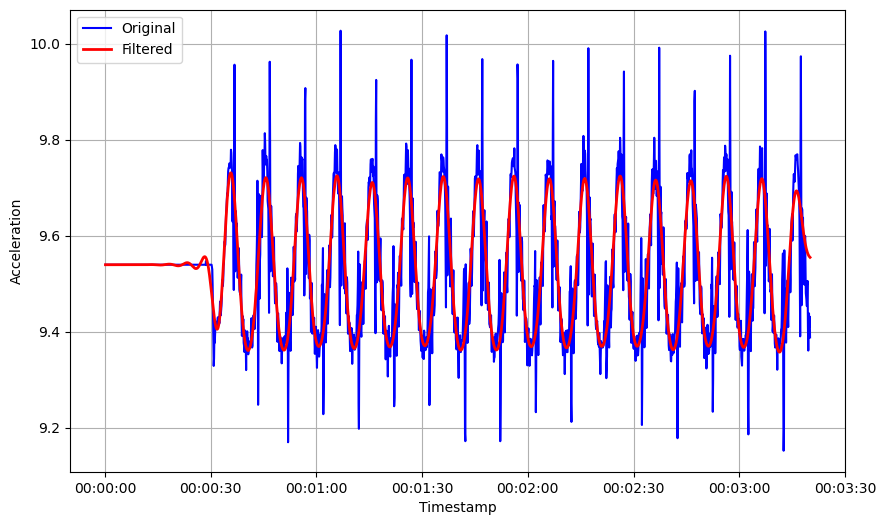

In [10]:
# Design the Butterworth filter
order = 8         # Filter order
cutoff_frequency = 0.04 # Cutoff frequency
b, a = signal.butter(order, cutoff_frequency, output='ba')

start_index = 13824000  # Start index of the range
# end_index = 13834000  # End index of the range
end_index = 13826000  # End index of the range
filtered_acceleration = signal.filtfilt(b, a, df['Acceleration'].iloc[start_index:end_index])

# Plot original and filtered acceleration
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'].iloc[start_index:end_index], df['Acceleration'].iloc[start_index:end_index], 'b-', label='Original')
plt.plot(df['Timestamp'].iloc[start_index:end_index], filtered_acceleration, 'r-', linewidth=2, label='Filtered')
plt.xlabel("Timestamp")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Select the first n data points of the 'Load' variable
length = 18000000
load_data = df['Load'].iloc[:length]

# window_size = 100  # Adjust as needed
# variance_values = load_data.rolling(window=window_size).var()
# normalized_variance = variance_values / np.max(variance_values)

window_size = 100
MA_window = 50
variance_values = load_data.rolling(window=window_size).var()
normalized_variance = variance_values / np.max(variance_values)
moving_average = normalized_variance.rolling(window=MA_window).mean()

threshold = 0.1  # Adjust as needed

# Identify inactive periods based on variance threshold
inactive_periods = moving_average < threshold

# Identify active and inactive regions
active_regions = []
inactive_regions = []
current_region_start = None

# Function to append region to the appropriate list
def append_region(region_start, region_end, is_inactive):
    if is_inactive:
        inactive_regions.append((region_start, region_end))
    else:
        active_regions.append((region_start, region_end))

# Iterate through the inactive_periods array to identify regions
for i, is_inactive in enumerate(inactive_periods):
    if is_inactive and current_region_start is None:
        current_region_start = i
    elif not is_inactive and current_region_start is not None:
        append_region(current_region_start, i - 1, True)
        current_region_start = None

if current_region_start is not None:
    append_region(current_region_start, len(inactive_periods) - 1, True)

# Identify active regions by finding stretches of False values
current_region_start = None
for i, is_inactive in enumerate(inactive_periods):
    if not is_inactive and current_region_start is None:
        current_region_start = i
    elif is_inactive and current_region_start is not None:
        append_region(current_region_start, i - 1, False)
        current_region_start = None

if current_region_start is not None:
    append_region(current_region_start, len(inactive_periods) - 1, False)

# Output the starting and stopping timestamps for each region
print("Active Regions:")
for idx, (start, stop) in enumerate(active_regions):
    print(f"Active Region #{idx + 1}: Start Time = {load_data.index[start]}, Stop Time = {load_data.index[stop]}")
#     print(f"Active Region #{idx + 1}: Start Time = {load_data.index[start]}, Stop Time = {load_data.index[stop]}, Run Time = {load_data.index[stop]-load_data.index[start]}")

print("\nInactive Regions:")
for idx, (start, stop) in enumerate(inactive_regions):
    print(f"Inactive Region #{idx + 1}: Start Time = {load_data.index[start]}, Stop Time = {load_data.index[stop]}")

Active Regions:
Active Region #1: Start Time = 0, Stop Time = 9138
Active Region #2: Start Time = 72078, Stop Time = 81122
Active Region #3: Start Time = 144080, Stop Time = 153125
Active Region #4: Start Time = 216080, Stop Time = 225122
Active Region #5: Start Time = 288080, Stop Time = 297124
Active Region #6: Start Time = 360080, Stop Time = 369121
Active Region #7: Start Time = 432080, Stop Time = 441121
Active Region #8: Start Time = 504079, Stop Time = 513121
Active Region #9: Start Time = 576080, Stop Time = 585085
Active Region #10: Start Time = 648044, Stop Time = 657085
Active Region #11: Start Time = 720045, Stop Time = 729085
Active Region #12: Start Time = 792044, Stop Time = 801088
Active Region #13: Start Time = 864044, Stop Time = 873146
Active Region #14: Start Time = 936081, Stop Time = 945125
Active Region #15: Start Time = 1008083, Stop Time = 1017125
Active Region #16: Start Time = 1080083, Stop Time = 1089125
Active Region #17: Start Time = 1152083, Stop Time = 1

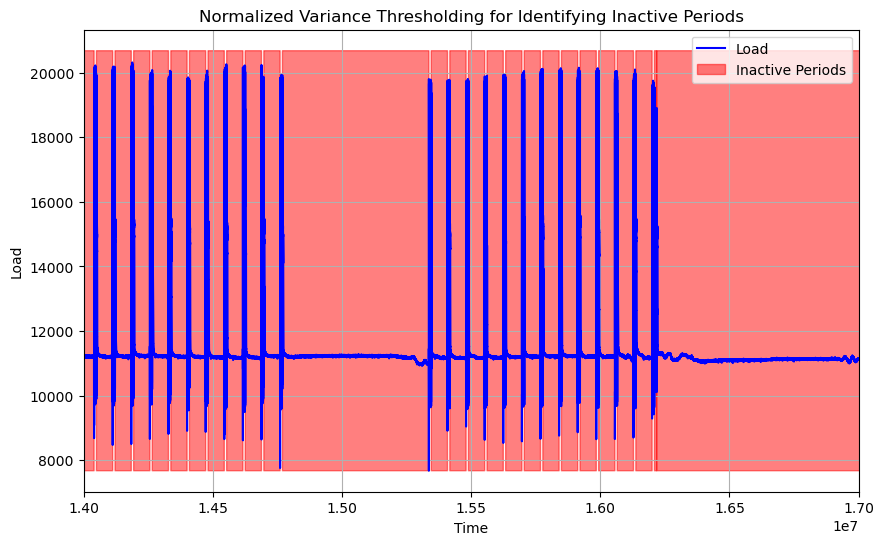

In [21]:
# Visualization of active/inactive pump regions

plt.figure(figsize=(10, 6))
plt.plot(load_data, color='blue', label='Load')
# plt.plot(normalized_variance, color='red', linestyle='--', label='Normalized Variance')
plt.fill_between(load_data.index, np.min(load_data), np.max(load_data), where=inactive_periods, color='red', alpha=0.5, label='Inactive Periods')
plt.title('Normalized Variance Thresholding for Identifying Inactive Periods')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.xlim(14000000,17000000)
plt.grid(True)
plt.show()

In [23]:
# Initialize arrays to store durations
active_durations = []
inactive_durations = []

# Iterate through each entry in active_regions
for start, stop in active_regions:
    duration = stop - start
    active_durations.append(duration)

# Iterate through each entry in inactive_regions
for start, stop in inactive_regions:
    duration = stop - start
    inactive_durations.append(duration)

# To exclude periods when the well was down for more than 12 hours let's convert that to indices
# The conversion reads: 12 hours * 60 min/hour * 60 sec/min * 10 indices/sec = 432,000 indices
# Any entry in inactive durations > 432,000 should be discarded for this calculation
downtime_cutoff = 432000

# Convert inactive_durations to a numpy array
inactive_durations = np.array(inactive_durations)

# Sort inactive_durations from highest to lowest
sorted_inactive_durations = inactive_durations[np.argsort(inactive_durations)[::-1]]
print("First 5 values of sorted inactive durations:",sorted_inactive_durations[:5])

print("Discarding values larger than downtime cutoff of:", downtime_cutoff)
# Discard values larger than downtime_cutoff
sorted_inactive_durations = sorted_inactive_durations[sorted_inactive_durations <= downtime_cutoff]

# Print the first 10 values of the cleaned array
print("First 5 values of sorted inactive durations post-cutoff:", sorted_inactive_durations[:5])
print("----------------------------------------------------------------------------------------")
# Sum the active array and the cleaned inactive array
total_active_time = np.sum(active_durations)
total_inactive_time = np.sum(sorted_inactive_durations)
# Print the total active/inactive time
print("Total active time:", total_active_time)
print("Total inactive time:", total_inactive_time)
print("----------------------------------------------------------------------------------------")
print("Percentage of dataset that is active:","{:.0f}%".format((total_active_time / total_inactive_time) * 100))

First 5 values of sorted inactive durations: [1781775  566896   63512   63484   63437]
Discarding values larger than downtime cutoff of: 432000
First 5 values of sorted inactive durations post-cutoff: [63512 63484 63437 63432 63357]
----------------------------------------------------------------------------------------
Total active time: 1984421
Total inactive time: 13666448
----------------------------------------------------------------------------------------
Percentage of dataset that is active: 15%


In [24]:
buff = 0.05

# Function to plot the specified region
def plot_region(is_active, region_number,leftzoom):
    regions = active_regions if is_active else inactive_regions
    if region_number <= len(regions):
        region_start, region_end = regions[region_number - 1]
        region_length = region_end - region_start
        buffer = int(buff * region_length)  # 5% buffer
        buffered_region_start = region_start + buffer
        buffered_region_end = region_end - buffer
        plt.figure(figsize=(10, 6))
        plt.plot(load_data[load_data.index[buffered_region_start]:load_data.index[buffered_region_end]], color='blue', label='Load')
        region_type = "Active" if is_active else "Inactive"
        plt.title(f'Load vs. Time in {region_type} Region #{region_number}')
        plt.xlabel('Time (Index)')
        plt.xlim(buffered_region_start + leftzoom * (buffered_region_end - buffered_region_start), buffered_region_end)
        plt.ylabel('Load')
        plt.grid(True)
        plt.show()
    else:
        print(f"Region #{region_number} does not exist.")

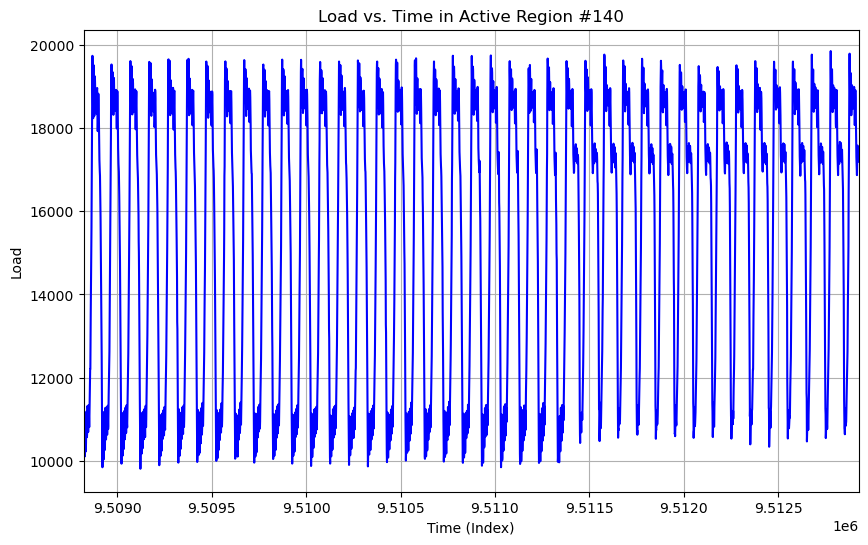

In [25]:
plot_region(True, 140, 0.5)

In [26]:
buff = 0.05

def smooth_active_accel(region_number):
    if region_number <= len(active_regions):
        start_index, end_index = active_regions[region_number - 1]
        region_length = end_index - start_index
        buffer = int(buff * region_length)  # buffer
        buffered_start_index = start_index + buffer
        buffered_end_index = end_index - buffer

        # Design the Butterworth filter for low-pass filtering
        order = 8                # Filter order
        cutoff_frequency = 0.04  # Cutoff frequency
        b_low, a_low = signal.butter(order, cutoff_frequency, output='ba')

        # Apply the low-pass filter to 'Acceleration' data
        filtered_acceleration = signal.filtfilt(b_low, a_low, df['Acceleration'].iloc[buffered_start_index:buffered_end_index])

        # Define the band-pass filter parameters
        low_cutoff = 0.01  # Lower cutoff frequency in Hz
        high_cutoff = 0.04  # Upper cutoff frequency in Hz
        order = 2           # Filter order

        # Design the Butterworth band-pass filter
        b_bandpass, a_bandpass = signal.butter(order, [low_cutoff, high_cutoff], btype='bandpass', analog=False)

        # Apply the band-pass filter to the filtered acceleration data
        filtered_data_bandpass = signal.filtfilt(b_bandpass, a_bandpass, filtered_acceleration)

#         # Plot the original filtered acceleration data and the band-pass filtered data
#         plt.figure(figsize=(10, 6))
#         #plt.plot(filtered_acceleration, label='Low-Pass Filtered Acceleration')
#         plt.plot(filtered_data_bandpass, label='Band-pass Filtered Acceleration')
#         plt.xlabel('Time (index)')
#         plt.ylabel('Acceleration')
#         plt.title(f'Low-Pass and Band-pass Filtered Acceleration for Active Region #{region_number}')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
        
        return filtered_data_bandpass
    else:
        print(f"Region #{region_number} does not exist.")

In [27]:
from scipy import integrate, signal
import numpy as np

def accel_to_vel(region_number):
    if region_number <= len(active_regions):
        # Smooth the acceleration data for the specified active region
        filtered_data_bandpass = smooth_active_accel(region_number)
        
        # Calculate time array with increments of 0.1 seconds
        time_in_seconds = np.arange(0, len(filtered_data_bandpass) * 0.1, 0.1)
        
        # If lengths are off by 1 or -1, remove one data point from the larger array
        if abs(len(time_in_seconds) - len(filtered_data_bandpass)) == 1:
            if len(time_in_seconds) > len(filtered_data_bandpass):
                time_in_seconds = time_in_seconds[:-1]
            else:
                filtered_data_bandpass = filtered_data_bandpass[:-1]
        
        # Perform numerical integration to calculate velocity
        vel = integrate.cumtrapz(filtered_data_bandpass, x=time_in_seconds, initial=0.1)
        
        # Apply high-pass filter to the velocity
        order_hp = 3           
        cutoff_frequency_hp = 0.013
        b_hp, a_hp = signal.butter(order_hp, cutoff_frequency_hp, btype='high', analog=False)
        hp_vel = signal.filtfilt(b_hp, a_hp, vel)

#         #Plot filtered velocity over time
#         plt.figure(figsize=(10, 6))
#         plt.plot(time_in_seconds, hp_vel, 'g-')
#         plt.xlim(0,100)
#         plt.xlabel("Time (seconds)")
#         plt.ylabel("Filtered Velocity")
#         plt.title(f'Low-Pass Filtered Numerically Integrated Velocity  for Active Region #{region_number}')
#         plt.grid(True)
#         plt.show()
        
        return hp_vel
    else:
        print(f"Region #{region_number} does not exist.")

In [28]:
def vel_to_pos(region_number):
    if region_number <= len(active_regions):
        hp_vel = accel_to_vel(region_number)
        # Calculate time array with increments of 0.1 seconds
        time_in_seconds = np.arange(0, len(hp_vel) * 0.1, 0.1)
        
        # If lengths are off by 1 or -1, remove one data point from the larger array
        if abs(len(time_in_seconds) - len(hp_vel)) == 1:
            if len(time_in_seconds) > len(hp_vel):
                time_in_seconds = time_in_seconds[:-1]
            else:
                hp_vel = hp_vel[:-1]
                
        pos = integrate.cumtrapz(hp_vel, x=time_in_seconds, initial=0)
        # Calculate the mean value of pos
        pos_mean = np.mean(pos)
        # Subtract the mean value from each element of pos
        pos = pos - pos_mean
        
#         # Plot position over time
#         plt.figure(figsize=(10, 6))
#         plt.plot(time_in_seconds, pos, 'b-')
#         plt.xlabel("Time (seconds)")
#         plt.xlim(0,100)
#         plt.ylabel("Position")
#         plt.title(f"Position vs. Time for Active Region #{region_number}")
#         plt.grid(True)
#         plt.show()
        
        return pos
    else:
        print(f"Region #{region_number} does not exist.")
        return None

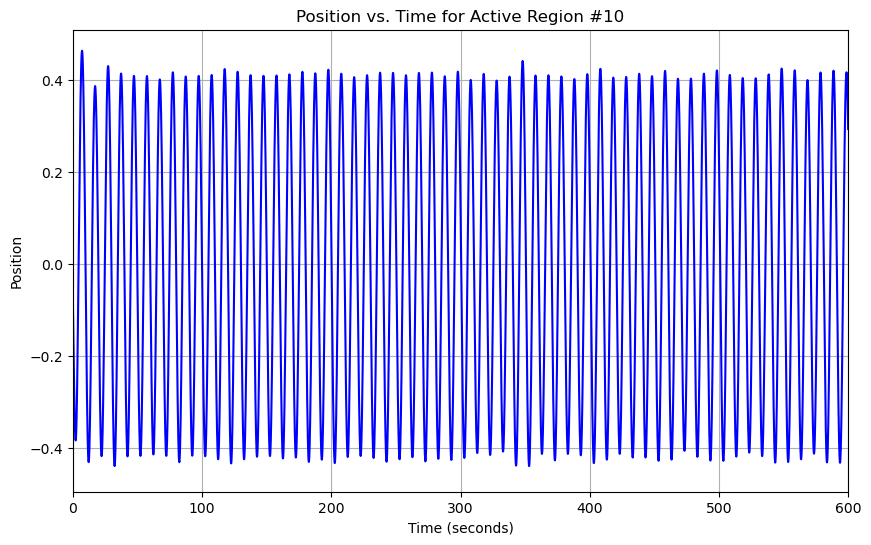

In [29]:
def vel_to_pos_plot(region_number):
    if region_number <= len(active_regions):
        hp_vel = accel_to_vel(region_number)
        # Calculate time array with increments of 0.1 seconds
        time_in_seconds = np.arange(0, len(hp_vel) * 0.1, 0.1)
        
        # If lengths are off by 1 or -1, remove one data point from the larger array
        if abs(len(time_in_seconds) - len(hp_vel)) == 1:
            if len(time_in_seconds) > len(hp_vel):
                time_in_seconds = time_in_seconds[:-1]
            else:
                hp_vel = hp_vel[:-1]
                
        pos = integrate.cumtrapz(hp_vel, x=time_in_seconds, initial=0)
        # Calculate the mean value of pos
        pos_mean = np.mean(pos)
        # Subtract the mean value from each element of pos
        pos = pos - pos_mean
        
        # Plot position over time
        plt.figure(figsize=(10, 6))
        plt.plot(time_in_seconds, pos, 'b-')
        plt.xlabel("Time (seconds)")
        plt.xlim(0,600)
        plt.ylabel("Position")
        plt.title(f"Position vs. Time for Active Region #{region_number}")
        plt.grid(True)
        plt.show()
        
    else:
        print(f"Region #{region_number} does not exist.")
        return None
    
vel_to_pos_plot(10)

In [30]:
buff = 0.05

def plot_load_vs_position(region_number):
    
    if region_number <= len(active_regions):
        start_index, end_index = active_regions[region_number - 1]
        region_length = end_index - start_index
        buffer = int(buff * region_length)
        buffered_start_index = start_index + buffer
        buffered_end_index = end_index - buffer
        
        # Obtain positions
        positions = vel_to_pos(region_number)
        
        # Extract Load values
        loads = df["Load"].iloc[buffered_start_index:buffered_end_index].values
        
        drop_number = 1
        positions = positions[drop_number:-drop_number]
        loads = loads[drop_number:-drop_number]
#         positions = positions[-500:]
#         loads = loads[-500:]

        # Create scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(positions, loads, color='blue', alpha=0.5, s=2)
        plt.xlabel("Position")
        plt.ylabel("Load")
        plt.title("Load vs. Position")
        plt.title(f"Surface Card of Load vs. Position for Active Region #{region_number}")
        plt.grid(True)
        plt.show()
        
    else:
        print(f"Region #{region_number} does not exist.")

In [33]:
# region_number_widget = widgets.IntSlider(min=130, max=150, description='Region Number', value=1)
# is_active_widget = widgets.Checkbox(value=True, description='Is Active')
# output = widgets.interactive(plot_region, region_number=region_number_widget, is_active=is_active_widget)
# display(output)

# Define widgets
region_number_widget = widgets.IntSlider(min=180, max=210, description='Region Number', value=1)
is_active_widget = widgets.Checkbox(value=True, description='Is Active')
leftzoom_widget = widgets.FloatSlider(min=0, max=0.95, step=0.05, description='Left Zoom', value=0.7)
# Create interactive output
output = widgets.interactive(plot_region, is_active=is_active_widget, region_number=region_number_widget, leftzoom=leftzoom_widget)
display(output)

interactive(children=(Checkbox(value=True, description='Is Active'), IntSlider(value=180, description='Region …

In [34]:
# Interface that outputs plots of load vs. position for all of the identified active regions
# Can quickly survey surface pump conditions to get a sense of the variation of the cards

print("Number of active regions:", len(active_regions))
widgets.interact(plot_load_vs_position, region_number=(150,230))

Number of active regions: 230


interactive(children=(IntSlider(value=190, description='region_number', max=230, min=150), Output()), _dom_cla…

<function __main__.plot_load_vs_position(region_number)>